In [0]:
#Download the dataset from opensig
import urllib.request
urllib.request.urlretrieve('http://opendata.deepsig.io/datasets/2016.10/RML2016.10a.tar.bz2', 'RML2016.10a.tar.bz2')

('RML2016.10a.tar.bz2', <http.client.HTTPMessage at 0x7f8afd310dd8>)

In [0]:
#decompress the .bz2 file into .tar file
import sys
import os
import bz2
zipfile = bz2.BZ2File('./RML2016.10a.tar.bz2') # open the file
data = zipfile.read() # get the decompressed data

In [0]:
#write the .tar file
open('./RML2016.10a.tar', 'wb').write(data) # write a uncompressed file

640952320

In [0]:
#extract the .tar file
import tarfile
my_tar = tarfile.open('./RML2016.10a.tar')
my_tar.extractall('./') # specify which folder to extract to
my_tar.close()

In [0]:
#extract the pickle file
import pickle
import numpy as np
Xd = pickle.load(open("RML2016.10a_dict.pkl",'rb'),encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

print('**Original dataset**')
print("Dataset has modulation types", mods)

print('\n')

#Check samples assigned to keys - each (mod, SNR) pair in dictionary 
print('**Samples in dataset**')
array_shape = []
print("Dictionary contains", len(Xd), "keys, meaning",len(Xd),"(mod, SNR) pairs" )
for k,v in Xd.items():
    array_shape.append(v.shape)
print("Each key or (mod,SNR) pair is assigned",set(array_shape), "array") 
print("This results in a total of",array_shape[0][0], "samples per (mod, SNR) pair, with each sample a",
      array_shape[0][1:3], "array")



**Original dataset**
Dataset has modulation types ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


**Samples in dataset**
Dictionary contains 220 keys, meaning 220 (mod, SNR) pairs
Each key or (mod,SNR) pair is assigned {(1000, 2, 128)} array
This results in a total of 1000 samples per (mod, SNR) pair, with each sample a (2, 128) array


In [0]:
#delete analogue modulation and keep only digital modulation schemes
mods_to_rmv = ['AM-DSB', 'AM-SSB', 'WBFM']  #mod names we need to remove
keys_to_rmv = [key for key in Xd.keys() if key[0] in mods_to_rmv]  #keys corresponding to all these mods
# we remove each key containing each of the analog mod types
Xd_digital = {key: Xd[key] for key in Xd if key not in keys_to_rmv}  #new dictionary containing only digital mod types
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd_digital.keys())))), [1,0])
print("   ")
print('**New dataset**')
print("Limit dataset to",len(list(mods)), "digital modulation schemes:", mods)



#Check samples assigned to keys - each (mod, SNR) pair in dictionary 
print('**Samples in dataset**')
array_shape = []
print("Dictionary contains", len(Xd_digital), "keys, meaning",len(Xd_digital),"(mod, SNR) pairs" )
for k,v in Xd_digital.items():
    array_shape.append(v.shape)
print("Each key or (mod,SNR) pair is assigned",set(array_shape), "array") 
print("This results in a total of",array_shape[0][0], "samples per (mod, SNR) pair, with each sample a",
      array_shape[0][1:3], "array")


#for keys,values in Xd_digital.items():
 #   print(keys)
 #   print(values)

   
**New dataset**
Limit dataset to 8 digital modulation schemes: ['8PSK', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK']
**Samples in dataset**
Dictionary contains 160 keys, meaning 160 (mod, SNR) pairs
Each key or (mod,SNR) pair is assigned {(1000, 2, 128)} array
This results in a total of 1000 samples per (mod, SNR) pair, with each sample a (2, 128) array


In [0]:
#Separate samples for training and test sets

from sklearn.utils import shuffle

print('**Separate samples for training and testing**')

Xd_shuffled = dict()
        
#Randomize the samples assigned to each key 
# we take each key: (mod type, snr) pair, and shuffle the samples within this group of values
for k,v in Xd_digital.items():
        v = shuffle(v, random_state=0)
        Xd_shuffled.update({k : v})
# So Xd_shuffled is just Xd_digital with samples belonging to each key shuffled         
#set train:test set ratio
train_test = 0.5
dict_test = dict()
dict_train = dict()
test_array_shape = []
train_array_shape = []

#extract the first 'train_test' fraction of samples to form test set and the rest to form training set
for k,v in Xd_shuffled.items(): 
        dict_test.update({k : v[:int(v.shape[0]*0.5), :]}) 
        dict_train.update({k : v[int(v.shape[0]*0.5):, :]})
# Take each (mod type, SNR) key. From these 1000 samples assigned to the key, take the first half and put them in test set
# (we already shuffled these samples earlier)

#check samples assgined to each key in dictionary dict_test and dict_train
for k,v in dict_test.items(): test_array_shape.append(v.shape)        
for k,v in dict_train.items(): train_array_shape.append(v.shape)

print("Training:Test set ratio = ", train_test)
print("Each key in training set is assigned",set(train_array_shape), "array")
print("Each key in test set is assigned",set(test_array_shape), "array")
print("This results in:")
print("      training set: a total of",train_array_shape[0][0], "samples per (mod, SNR) pair")
print("      test set: a total of",test_array_shape[0][0], "samples per (mod, SNR) pair")

**Separate samples for training and testing**
Training:Test set ratio =  0.5
Each key in training set is assigned {(500, 2, 128)} array
Each key in test set is assigned {(500, 2, 128)} array
This results in:
      training set: a total of 500 samples per (mod, SNR) pair
      test set: a total of 500 samples per (mod, SNR) pair


In [0]:
from keras.utils import to_categorical
X_train = []  
labels_train = []
for mod in mods:
    for snr in snrs:
        X_train.append(dict_train[(mod,snr)])
        for i in range(dict_train[(mod,snr)].shape[0]): 
            labels_train.append((mod,snr))
#print(labels_train[200][0])
#print(labels_train[1000][0])
#print(labels_train[2000][0])
#print(labels_train[50000][0])
#print(labels_train[60000][0])
#print(labels_train[70000][0])
print(labels_train)
print(mods.index(labels_train[501][0]))
X_train = np.vstack(X_train)
n_samples_train = X_train.shape[0]
y_train = np.array(list(map(lambda x: mods.index(labels_train[x][0]), range(n_samples_train))))

print("**Training data (raw data)**")

y_train = to_categorical(y_train)

print(X_train.shape,"training data, ", y_train.shape, "labels")

Using TensorFlow backend.


[('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', -20), ('8PSK', 

In [0]:
n_samples = X_train.shape[0]
rows = X_train.shape[1]
vec_len = X_train.shape[2]
X_complex = []
X_complex = [complex(X_train[samp_num,0,column],X_train[samp_num,1,column]) 
              for samp_num in range(n_samples) for column in range(vec_len)]

X_complex = np.vstack(X_complex)
X_complex = np.reshape(X_complex, [n_samples,vec_len])
X_complex_sqr = np.square(X_complex)
X_complex_angl = np.angle(X_complex)


print(X_complex)
print(X_complex_sqr)


    

[[ 3.18319141e-03+0.00538155j -3.00938985e-03+0.00055957j
  -2.77712033e-03-0.00560239j ...  5.88704646e-03-0.00072972j
   7.72206113e-03+0.00840547j -4.39487863e-03+0.00371041j]
 [-2.71051168e-03-0.0033999j   3.66036850e-03+0.00700086j
   8.25517997e-03-0.00562896j ...  6.71843532e-03-0.00657255j
  -2.17485308e-06+0.00285328j  7.06360443e-03-0.00530591j]
 [-4.47546691e-03-0.01089563j -1.85837154e-03+0.00520189j
  -3.84704373e-03-0.0014153j  ... -1.23027191e-02-0.00641734j
   7.29953824e-03-0.00015643j -7.46383937e-03+0.00419801j]
 ...
 [-1.32474862e-03-0.00575703j  6.31370232e-04-0.0029766j
   2.42744270e-03-0.00015242j ... -6.22222619e-03+0.00642272j
  -7.43356999e-03+0.00501108j -8.37847032e-03+0.0033758j ]
 [-2.92500015e-03-0.00810628j -4.53897845e-03-0.00853034j
  -5.56885963e-03-0.00820594j ... -3.12470132e-03+0.00416254j
  -8.01588409e-04+0.00467056j  1.65861135e-03+0.00537926j]
 [ 8.54930666e-04+0.00216952j  3.16628539e-05-0.00052336j
  -8.01926595e-04-0.00337807j ...  1.010801

In [0]:
#Form expert features 

def form_features(X):
    
    #Form array of complex numbers; convert each (2,128) sample to a (128,) sample
    
    n_samples = X.shape[0]
    rows = X.shape[1]
    vec_len = X.shape[2]
    X_complex = []
    X_complex = [complex(X[samp_num,0,column],X[samp_num,1,column]) 
                 for samp_num in range(n_samples) for column in range(vec_len)]
    
    X_complex = np.vstack(X_complex)
    X_complex = np.reshape(X_complex, [n_samples,vec_len])
    X_complex_sqr = np.square(X_complex)
    X_complex_angl = np.angle(X_complex)
    
    #Form features: set of 16 expert features based on 0 cyclic time lag

    dict_16features = {}
    
    #Feature 1
    dict_16features['f1'] = np.array([np.mean(X_complex, axis=1)]).T

    #Feature 2
    dict_16features['f2'] = np.array([np.mean(abs(X_complex),axis = 1)]).T
    
    #Feature 3
    dict_16features['f3'] = np.array([np.mean(X_complex_angl, axis = 1)]).T

    #Feature 4
    dict_16features['f4'] = np.array([np.mean(abs(X_complex_angl), axis = 1)]).T

    #Feature 5
    dict_16features['f5'] = np.array([np.mean(X_complex_sqr, axis = 1)]).T

    #Feature 6
    dict_16features['f6'] = np.array([np.mean(np.square(abs(X_complex)), axis = 1)]).T

    #Feature 7
    dict_16features['f7'] = np.array([np.mean(np.square(X_complex_angl), axis = 1)]).T

    #Feature 8
    dict_16features['f8'] = np.array([np.mean(np.square(abs(X_complex_angl)), axis = 1)]).T

    #Feature 9
    dict_16features['f9'] = np.array([(np.mean(X_complex_sqr,axis = 1)) - 
                   ((1/vec_len**2)*np.square(np.sum(X_complex, axis = 1)))]).T

    #Feature 10
    dict_16features['f10'] = np.array([(np.mean(np.square(abs(X_complex)), axis = 1)) - 
                    ((1/vec_len**2)*np.square(np.sum(abs(X_complex), axis = 1)))]).T

    #Feature 11
    dict_16features['f11'] = np.array([(np.mean(np.square(X_complex_angl),axis = 1)) - 
                    ((1/vec_len**2)*np.square(np.sum(X_complex_angl, axis = 1)))]).T

    #Feature 12
    dict_16features['f12'] = np.array([(np.mean(np.square(abs(X_complex_angl)), axis = 1)) - 
                    ((1/vec_len**2)* np.square(np.sum(abs(X_complex_angl), axis = 1)))]).T

    #Feature 13
    dict_16features['f13'] = np.array([(np.mean(np.power(X_complex,4), axis = 1)) - 
                    ((1/vec_len**2)*(np.sum(X_complex_sqr,1))**2)]).T

    #Feature 14
    dict_16features['f14'] = np.array([(np.mean(np.power(abs(X_complex),4), axis = 1)) - 
                   ((1/vec_len**2)*(np.sum(np.square(abs(X_complex)), axis = 1))**2)]).T

    #Feature 15
    dict_16features['f15'] = np.array([(np.mean(np.power(X_complex_angl,4), axis =1)) - 
                   ((1/vec_len**2)*(np.sum(np.square(X_complex_angl),axis = 1))**2)]).T

    #Feature 16
    dict_16features['f16'] = np.array([(np.mean(np.power(abs(X_complex_angl),4), axis =1) - 
                   ((1/vec_len**2)*(np.sum(np.square(abs(X_complex_angl)),axis = 1))**2))]).T 

    #Concatenate 16 feature arrays
    X_16 = []
    X_16 += dict_16features.values()
    X_16 = abs(np.hstack(np.array(X_16)))
    
    return X_16

In [0]:
#Preprocess the training data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
#shuffle the samples
X_train, y_train = shuffle(X_train, y_train)

#form features 
X_16_train = form_features(X_train)

#standardize the features
sc = StandardScaler()
sc.fit(X_16_train)
X_train_std = sc.transform(X_16_train)

print("**Training data after preprocessing**")
print("           - samples have", X_train_std.shape[1], "features")
print(X_train_std.shape,"training data, ", y_train.shape, "labels")

**Training data after preprocessing**
           - samples have 16 features
(80000, 16) training data,  (80000, 8) labels


In [0]:
#Form and preprocess test data
from collections import defaultdict
# new defaultdict with keys = SNR values and values = (2,128) samples  
test_data = defaultdict(list)
test_labels = defaultdict(list)

# Extract all samples corresponding to each SNR value
# dict_test had keys of the form (mod type, SNR); new dict test_data has keys (SNR)
def form_test_data(snr):
    for k,v in dict_test.items():
        if k[1] == snr: 
            test_data[snr].append(v)
            for x in range(v.shape[0]): 
                test_labels[snr].append(k[0]) 
    test_data[snr] = np.vstack(test_data[snr])
    test_labels[snr] = np.vstack(test_labels[snr])
    n_samples_test = test_data[snr].shape[0]
    test_labels[snr] = np.array(list(map(lambda x: mods.index(test_labels[snr][x]), range(n_samples_test))))
    return test_data[snr], test_labels[snr]
    
X_test = defaultdict(list)
X_test16 = defaultdict(list)
y_test = defaultdict(list)
X_test_std = defaultdict(list)

# Extract samples and labels for each SNR 
for snr in snrs:
    data, labels = form_test_data(snr)     # extract all samples belonging to this SNR, from dict_test
    X_test[snr].append(data)
    X_test[snr] = np.vstack(X_test[snr])
    y_test[snr].append(labels)             # extract the corresponding labels belonging to this SNR, from dict_test
    y_test[snr] = np.hstack(y_test[snr])
    X_test[snr], y_test[snr] = shuffle(X_test[snr], y_test[snr])  #shuffle the samples (2, 128)
    X_test16[snr] = form_features(X_test[snr])   #form features; each sample is now (16,) feature vector 
    X_test_std[snr] = sc.transform(X_test16[snr])    #standardize the features
    
print("**Test data**")
print("Separate arrays for samples corresponding to different SNRs")
print("Total", len(snrs), X_test_std[18].shape, "arrays for SNR values", snrs)

**Test data**
Separate arrays for samples corresponding to different SNRs
Total 20 (4000, 16) arrays for SNR values [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [0]:
%store snrs
%store X_train_std
%store X_test_std
%store y_train
%store y_test

Stored 'snrs' (list)
Stored 'X_train_std' (ndarray)
Stored 'X_test_std' (defaultdict)
Stored 'y_train' (ndarray)
Stored 'y_test' (defaultdict)


In [0]:
#Form expert features 

def form_next16_features(X):
    
    #Form array of complex numbers; convert each (2,128) sample to a (128,) sample
    
    n_samples = X.shape[0]
    rows = X.shape[1]
    vec_len = X.shape[2]
    X_complex = []
    X_complex = [complex(X[samp_num,0,column],X[samp_num,1,column]) 
                 for samp_num in range(n_samples) for column in range(vec_len)]
    
    X_complex = np.vstack(X_complex)
    X_complex = np.reshape(X_complex, [n_samples,vec_len])
    
    #Form array to use in features based on 8 cyclic time lag

    X_complex_8lag = np.zeros((X_complex.shape), dtype=complex)
    for samp_num in range(n_samples):
        for clmn in range(vec_len):
            shift_by = (clmn + 8)%vec_len
            X_complex_8lag[samp_num,clmn] = (X_complex[samp_num,clmn])*(X_complex[samp_num,shift_by])
            
    X_complex8_sqr = np.square(X_complex_8lag)
    X_complex8_angl = np.angle(X_complex_8lag)
    
    #16 expert features based on 8 cyclic time lag
    
    dict_16features = {}
    
    #Feature 17
    dict_16features['f17'] = np.array([np.mean(X_complex_8lag, axis = 1)]).T

    #Feature 18
    dict_16features['f18'] = np.array([np.mean(abs(X_complex_8lag),axis = 1)]).T

    #Feature 19
    dict_16features['f19'] = np.array([np.mean(X_complex8_angl, axis = 1)]).T

    #Feature 20
    dict_16features['f20'] = np.array([np.mean(abs(X_complex8_angl), axis = 1)]).T

    #Feature 21
    dict_16features['f21'] = np.array([np.mean(X_complex8_sqr, axis = 1)]).T

    #Feature 22
    dict_16features['f22'] = np.array([np.mean(np.square(abs(X_complex_8lag)), axis = 1)]).T

    #Feature 23
    dict_16features['f23'] = np.array([np.mean(np.square(X_complex8_angl), axis = 1)]).T

    #Feature 24
    dict_16features['f24'] = np.array([np.mean(np.square(abs(X_complex8_angl)), axis = 1)]).T

    #Feature 25
    dict_16features['f25'] = np.array([(np.mean(X_complex8_sqr,axis = 1)) - 
                    ((1/vec_len**2)*np.square(np.sum(X_complex_8lag, axis = 1)))]).T

    #Feature 26
    dict_16features['f26'] = np.array([(np.mean(np.square(abs(X_complex_8lag)), axis = 1)) -
                    ((1/vec_len**2)*np.square(np.sum(abs(X_complex_8lag), axis = 1)))]).T

    #Feature 27
    dict_16features['f27'] = np.array([(np.mean(np.square(X_complex8_angl),axis = 1)) -
              ((1/vec_len**2)*np.square(np.sum(X_complex8_angl, axis = 1)))]).T

    #Feature 28
    dict_16features['f28'] = np.array([(np.mean(np.square(abs(X_complex8_angl)), axis = 1)) - 
             ((1/vec_len**2)* np.square(np.sum(abs(X_complex8_angl), axis = 1)))]).T

    #Feature 29
    dict_16features['f29'] = np.array([(np.mean(np.power(X_complex_8lag,4), axis = 1)) - 
                    ((1/vec_len**2)*(np.sum(X_complex8_sqr,1))**2)]).T

    #Feature 30
    dict_16features['f30'] = np.array([(np.mean(np.power(abs(X_complex_8lag),4), axis = 1)) - 
             ((1/vec_len**2)*(np.sum(np.square(abs(X_complex_8lag)), axis = 1))**2)]).T

    #Feature 31
    dict_16features['f31'] = np.array([((1/vec_len)* np.sum(np.power(X_complex8_angl,4), axis =1)) - 
                     ((1/vec_len**2)*(np.sum(np.square(X_complex8_angl),axis = 1))**2)]).T

    #Feature 32
    dict_16features['f32'] = np.array([(np.mean(np.power(abs(X_complex8_angl),4), axis =1) - 
             ((1/vec_len**2)*(np.sum(np.square(abs(X_complex8_angl)),axis = 1))**2))]).T

    #Concatenate 16 feature arrays
    X_16 = []
    X_16 += dict_16features.values()
    X_16 = abs(np.hstack(np.array(X_16)))
    
    return X_16


In [0]:

#Preprocess the training data

#form features 
X_next16_train = form_next16_features(X_train)

# combine the previous 16 features with these next 16 features, to create (n_samples, 32) data
X_32_train = np.concatenate((X_16_train, X_next16_train), axis = 1)

#standardize the features
sc = StandardScaler()
sc.fit(X_32_train)
X_32train_std = sc.transform(X_32_train)

print("**Training data after preprocessing**")
print("           - samples have", X_32train_std.shape[1], "features")
print(X_32train_std.shape,"training data, ", y_train.shape, "labels")

**Training data after preprocessing**
           - samples have 32 features
(80000, 32) training data,  (80000, 8) labels


In [0]:
#Form and preprocess test data
    
X_next16test = defaultdict(list)
X_32test_std = defaultdict(list)
X_32test = defaultdict(list)

for snr in snrs:

  X_next16test[snr] = form_next16_features(X_test[snr])   # form the next 16 features
  # concatenate the previous 16 and these next 16 features, so total 32 features
  X_32test[snr] = np.concatenate((X_test16[snr], X_next16test[snr]), axis = 1)   
  X_32test_std[snr] = sc.transform(X_32test[snr])    #standardize the features

print("**Test data**")
print("Separate arrays for samples corresponding to different SNRs")
print("Total", len(snrs), X_32test_std[18].shape, "arrays for SNR values", snrs)



**Test data**
Separate arrays for samples corresponding to different SNRs
Total 20 (4000, 32) arrays for SNR values [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [0]:

y_32_train = y_train
y_32_test = y_test

print(y_32_train.shape)
print(y_32_test)

(80000, 8)
defaultdict(<class 'list'>, {-20: array([4, 1, 5, ..., 6, 4, 1]), -18: array([6, 6, 2, ..., 6, 1, 0]), -16: array([6, 6, 7, ..., 4, 6, 1]), -14: array([6, 7, 2, ..., 0, 2, 3]), -12: array([0, 4, 2, ..., 1, 5, 6]), -10: array([7, 2, 5, ..., 6, 0, 1]), -8: array([0, 0, 4, ..., 5, 1, 3]), -6: array([5, 1, 4, ..., 2, 7, 2]), -4: array([1, 5, 2, ..., 3, 0, 5]), -2: array([0, 1, 1, ..., 7, 4, 3]), 0: array([0, 0, 6, ..., 0, 1, 3]), 2: array([7, 4, 6, ..., 0, 5, 5]), 4: array([4, 1, 2, ..., 7, 5, 3]), 6: array([7, 6, 5, ..., 1, 6, 4]), 8: array([6, 3, 3, ..., 7, 5, 2]), 10: array([5, 6, 6, ..., 6, 5, 1]), 12: array([4, 5, 0, ..., 1, 3, 5]), 14: array([7, 0, 7, ..., 6, 1, 3]), 16: array([3, 6, 1, ..., 1, 1, 1]), 18: array([7, 4, 6, ..., 6, 3, 7])})


In [0]:

%store X_32train_std
%store X_32test_std
%store y_32_train
%store y_32_test

Stored 'X_32train_std' (ndarray)
Stored 'X_32test_std' (defaultdict)
Stored 'y_32_train' (ndarray)
Stored 'y_32_test' (defaultdict)


In [0]:

%store

Stored variables and their in-db values:
X_32test_std              -> defaultdict(<class 'list'>, {-20: array([[-0.92122
X_32train_std             -> array([[ 4.01452303,  0.20017003,  5.6230475 , ...
X_test_std                -> defaultdict(<class 'list'>, {-20: array([[-0.92122
X_train_std               -> array([[ 4.01452303,  0.20017003,  5.6230475 , ...
snrs                      -> [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 
y_32_test                 -> defaultdict(<class 'list'>, {-20: array([4, 1, 5, 
y_32_train                -> array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 
y_test                    -> defaultdict(<class 'list'>, {-20: array([4, 1, 5, 
y_train                   -> array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 


In [0]:
print("Training data: ", X_32train_std.shape, "and labels: ", y_32_train.shape)
print(" ")
print("Test data:")
print("Total", len(X_32test_std), X_32test_std[18].shape, "arrays for SNR values:")
print(sorted(X_32test_std.keys()))

print(y_32_train)

Training data:  (80000, 32) and labels:  (80000, 8)
 
Test data:
Total 20 (4000, 32) arrays for SNR values:
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
X_val = []
y_val = []

X_test_new = defaultdict(list)
y_test_new = defaultdict(list)


for snr in snrs:
  n_test = X_32test_std[snr].shape[0]
  n = int(n_test*0.2)
  X_val.append(X_32test_std[snr][:n,:])
  y_val.append(y_32_test[snr][:n])
  X_test_new[snr] = X_32test_std[snr][n:]
  y_test_new[snr] = y_32_test[snr][n:]

X_val = np.vstack(np.asarray(X_val))
y_val =np.hstack(np.asarray(y_val))


X_32test_std = X_test_new
y_32_test = y_test_new
X_32_val = X_val
y_32_val = y_val
y_32_val = to_categorical(y_32_val)

print("Validation set data", X_32_val.shape, "and labels",y_32_val.shape)

print(type(X_32test_std))

print("Total", len(X_32test_std), X_32test_std[18].shape, "arrays for SNR values:")


Validation set data (16000, 32) and labels (16000, 8)
<class 'collections.defaultdict'>
Total 20 (3200, 32) arrays for SNR values:


In [0]:

import keras
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 256, kernel_initializer = 'he_normal', activation = 'relu', input_dim = 32))
dout = 0.1
classifier.add(Dropout(rate = dout))

# Adding the second hidden layer
classifier.add(Dense(units = 256, kernel_initializer = 'he_normal', activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Dense(units = 128, kernel_initializer = 'he_normal', activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Dense(units = 64, kernel_initializer = 'he_normal', activation = 'relu'))
classifier.add(Dropout(rate = dout))

# Adding the output layer
classifier.add(Dense(units = 8, kernel_initializer = 'he_normal', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#logger = keras.callbacks.TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=0)

classifier.summary()

print("Model Created!")






Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               8448      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

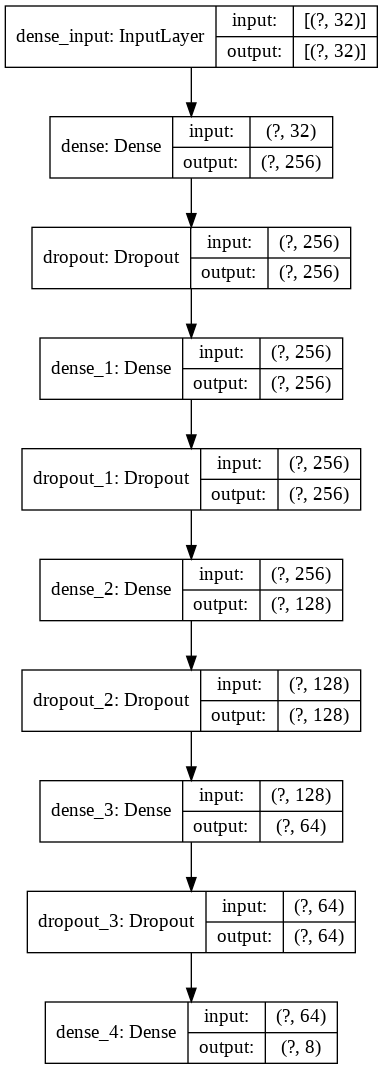

In [0]:
from tensorflow.keras.utils import plot_model

plot_model(classifier, show_shapes = True, to_file='model.png')

In [0]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size
import time
t_0=time.time()

filepath = 'cumulants_dropout.wts.h5'
history = classifier.fit(X_32train_std, y_32_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
      validation_data=(X_32_val, y_32_val),
    callbacks = [
        tensorflow.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

delta_t=time.time()-t_0
print(delta_t)
# we re-load the best weights once training is finished
classifier.load_weights(filepath)

Epoch 1/100
79/79 - 0s - loss: 1.7580 - accuracy: 0.2968 - val_loss: 1.5143 - val_accuracy: 0.3789
Epoch 2/100
79/79 - 0s - loss: 1.5324 - accuracy: 0.3734 - val_loss: 1.3810 - val_accuracy: 0.4244
Epoch 3/100
79/79 - 0s - loss: 1.4436 - accuracy: 0.4036 - val_loss: 1.3285 - val_accuracy: 0.4383
Epoch 4/100
79/79 - 0s - loss: 1.3988 - accuracy: 0.4204 - val_loss: 1.3129 - val_accuracy: 0.4436
Epoch 5/100
79/79 - 0s - loss: 1.3681 - accuracy: 0.4332 - val_loss: 1.2877 - val_accuracy: 0.4542
Epoch 6/100
79/79 - 0s - loss: 1.3489 - accuracy: 0.4394 - val_loss: 1.2781 - val_accuracy: 0.4527
Epoch 7/100
79/79 - 0s - loss: 1.3387 - accuracy: 0.4435 - val_loss: 1.2702 - val_accuracy: 0.4568
Epoch 8/100
79/79 - 0s - loss: 1.3263 - accuracy: 0.4486 - val_loss: 1.2601 - val_accuracy: 0.4602
Epoch 9/100
79/79 - 0s - loss: 1.3165 - accuracy: 0.4503 - val_loss: 1.2616 - val_accuracy: 0.4604
Epoch 10/100
79/79 - 0s - loss: 1.3076 - accuracy: 0.4545 - val_loss: 1.2544 - val_accuracy: 0.4639
Epoch 11/

In [0]:
for snr in snrs:
  y_32_test[snr] = to_categorical(y_32_test[snr])

In [0]:
acc_test = {}
for snr in snrs:
  print(snr)
  scscore = classifier.evaluate(X_32test_std[snr], y_32_test[snr])
  print(classifier.metrics_names)
  print (scscore)
  print("DNN's test accuracy on %d dB SNR samples = "%(snr), scscore[1])
  print('\n')
  acc_test[snr] = scscore

-20
100/100 [==============================] - 0s 2ms/step - loss: 2.1163 - accuracy: 0.1278
['loss', 'accuracy']
[2.1163344383239746, 0.12781250476837158]
DNN's test accuracy on -20 dB SNR samples =  0.12781250476837158


-18
100/100 [==============================] - 0s 2ms/step - loss: 2.1143 - accuracy: 0.1216
['loss', 'accuracy']
[2.114344358444214, 0.12156250327825546]
DNN's test accuracy on -18 dB SNR samples =  0.12156250327825546


-16
100/100 [==============================] - 0s 2ms/step - loss: 2.1052 - accuracy: 0.1322
['loss', 'accuracy']
[2.105233669281006, 0.13218750059604645]
DNN's test accuracy on -16 dB SNR samples =  0.13218750059604645


-14
100/100 [==============================] - 0s 2ms/step - loss: 2.0983 - accuracy: 0.1331
['loss', 'accuracy']
[2.098320484161377, 0.13312500715255737]
DNN's test accuracy on -14 dB SNR samples =  0.13312500715255737


-12
100/100 [==============================] - 0s 2ms/step - loss: 2.0636 - accuracy: 0.1412
['loss', 'accuracy

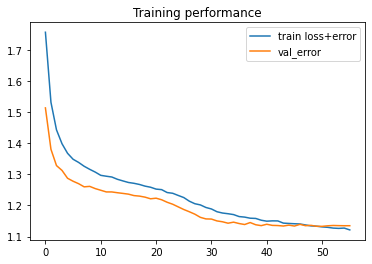

In [0]:
# Show loss curves 
# Show loss curves 
from matplotlib import pyplot as plt
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

[0.12781250476837158, 0.12156250327825546, 0.13218750059604645, 0.13312500715255737, 0.14124999940395355, 0.18062500655651093, 0.28187501430511475, 0.38343751430511475, 0.4193750023841858, 0.49312499165534973, 0.5762500166893005, 0.6909375190734863, 0.8106250166893005, 0.8349999785423279, 0.8231250047683716, 0.8368750214576721, 0.8415625095367432, 0.831250011920929, 0.8293750286102295, 0.8378124833106995]


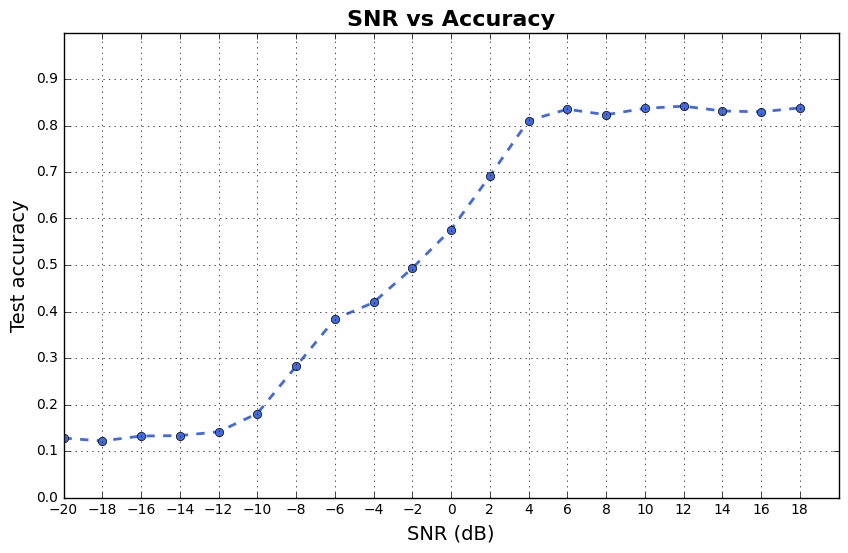

In [0]:
#####visualize performance

plt.style.use('classic')
%matplotlib inline

acc_test_li = sorted(acc_test.items())
new_acc = []
for i in range(len(acc_test_li)):
    new_acc.append(acc_test_li[i][1][1])
acc_test_values = new_acc 

fig1 = plt.figure(figsize=(10, 6), dpi=100)
x = snrs
y = list(acc_test_values)
print(y)
plt.plot(x, y, marker="o", linewidth=2.0, linestyle='dashed', color='royalblue')
plt.axis([-20, 20, 0, 1])
plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.yticks(np.arange(0, 1, 0.10))

ttl = plt.title('SNR vs Accuracy', fontsize=16)
ttl.set_weight('bold')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Test accuracy', fontsize=14)
plt.grid()

plt.show()

In [0]:
print(X_32test_std[18])

predicted_18dB = np.argmax(classifier.predict(X_32test_std[18], batch_size=batch_size),axis=1)
print(predicted_18dB)
print(y_32_test[18])
print('\n')
print(y_32_test[18])


[[ 1.18286680e+00  4.68957019e-01  1.56972231e+00 ... -1.36551179e-02
   2.48320279e-01  2.48320279e-01]
 [ 1.18471412e+00 -6.60395029e-01  6.49760985e-02 ... -1.37238799e-02
   2.24238504e-01  2.24238504e-01]
 [-1.22995796e+00 -6.63325727e-01  1.72194770e+00 ... -1.35889726e-02
  -2.12227210e+00 -2.12227210e+00]
 ...
 [ 2.58359516e+00  3.08918595e-01  3.74861347e+00 ... -1.36486164e-02
   3.34549411e-03  3.34549411e-03]
 [ 3.22324730e+00 -5.57942252e-01 -8.41184638e-01 ... -1.37549691e-02
  -5.38853843e-01 -5.38853843e-01]
 [ 8.50653549e-02 -1.76030786e-02  6.77847528e-01 ... -1.36335889e-02
   9.39303858e-01  9.39303858e-01]]
[7 0 1 ... 5 3 7]
[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [0]:
from sklearn.metrics import confusion_matrix
%matplotlib inline
for snr in snrs:
    y_32_test[snr] = np.argmax(y_32_test[snr],axis=1)



Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.12  0.13   0.13  0.11  0.12   0.13   0.14  0.13
BPSK   0.14  0.10   0.12  0.15  0.14   0.14   0.12  0.09
CPFSK  0.12  0.14   0.14  0.11  0.12   0.10   0.13  0.15
GFSK   0.18  0.15   0.09  0.15  0.13   0.09   0.16  0.05
PAM4   0.22  0.09   0.13  0.22  0.17   0.04   0.04  0.09
QAM16  0.08  0.15   0.15  0.15  0.08   0.08   0.08  0.23
QAM64  0.15  0.25   0.10  0.05  0.25   0.05   0.15  0.00
QPSK   0.12  0.12   0.11  0.14  0.12   0.13   0.13  0.13


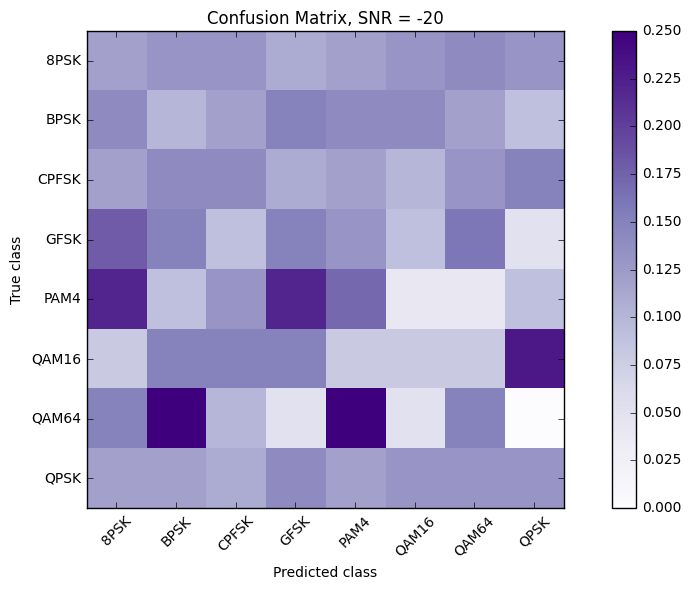

Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.13  0.12   0.12  0.12  0.12   0.14   0.12  0.13
BPSK   0.11  0.12   0.10  0.13  0.14   0.11   0.14  0.15
CPFSK  0.15  0.15   0.11  0.13  0.11   0.11   0.12  0.12
GFSK   0.07  0.05   0.09  0.16  0.11   0.18   0.19  0.14
PAM4   0.06  0.15   0.15  0.18  0.12   0.15   0.09  0.12
QAM16  0.19  0.06   0.19  0.12  0.12   0.06   0.06  0.19
QAM64  0.06  0.18   0.00  0.06  0.12   0.12   0.18  0.29
QPSK   0.12  0.13   0.13  0.14  0.13   0.12   0.12  0.12


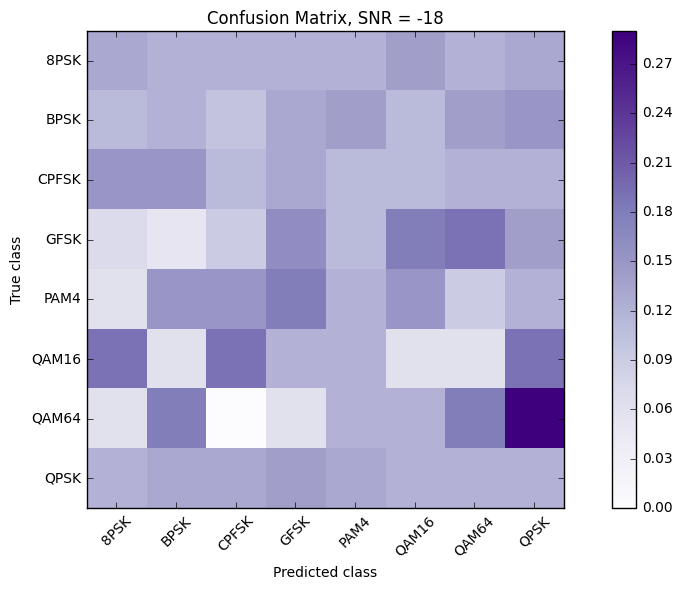

Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.14  0.10   0.14  0.13  0.10   0.13   0.14  0.11
BPSK   0.13  0.14   0.12  0.11  0.13   0.13   0.12  0.12
CPFSK  0.12  0.14   0.13  0.12  0.12   0.12   0.12  0.12
GFSK   0.11  0.11   0.09  0.09  0.13   0.10   0.24  0.11
PAM4   0.04  0.07   0.14  0.11  0.18   0.11   0.18  0.18
QAM16  0.10  0.19   0.05  0.14  0.10   0.10   0.24  0.10
QAM64  0.17  0.17   0.11  0.22  0.06   0.17   0.11  0.00
QPSK   0.13  0.12   0.12  0.12  0.13   0.13   0.11  0.13


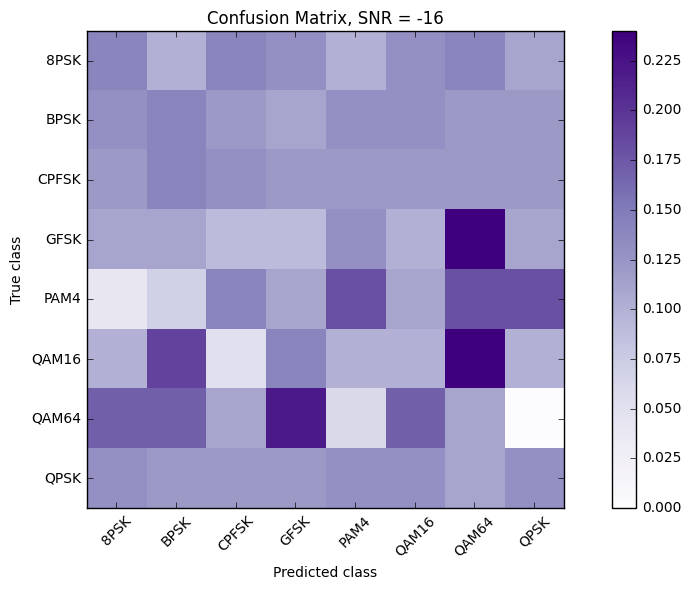

Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.12  0.14   0.13  0.12  0.12   0.12   0.12  0.13
BPSK   0.14  0.11   0.16  0.13  0.10   0.11   0.10  0.14
CPFSK  0.13  0.11   0.12  0.15  0.14   0.14   0.13  0.09
GFSK   0.11  0.05   0.08  0.14  0.08   0.14   0.31  0.08
PAM4   0.14  0.05   0.14  0.10  0.19   0.10   0.19  0.10
QAM16  0.00  0.10   0.00  0.10  0.20   0.25   0.30  0.05
QAM64  0.06  0.14   0.00  0.11  0.09   0.20   0.37  0.03
QPSK   0.13  0.13   0.12  0.12  0.14   0.11   0.10  0.14


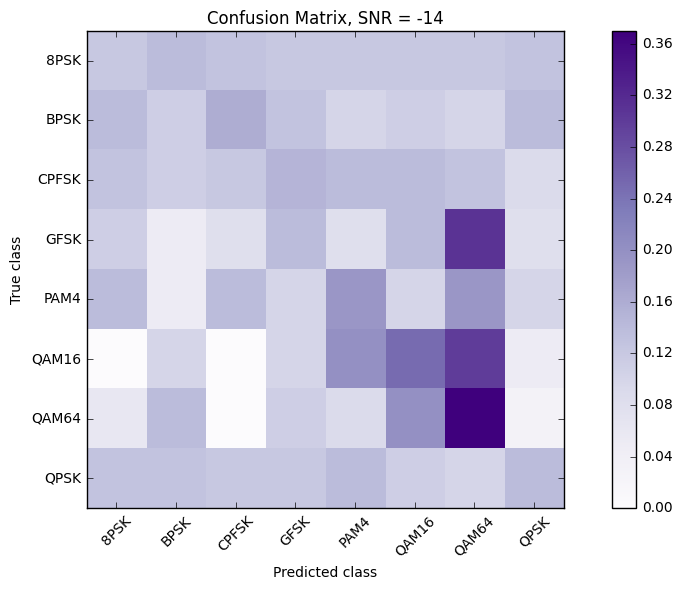

Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.12  0.13   0.15  0.11  0.12   0.13   0.13  0.11
BPSK   0.15  0.11   0.11  0.12  0.15   0.12   0.10  0.14
CPFSK  0.15  0.11   0.13  0.14  0.12   0.12   0.10  0.14
GFSK   0.05  0.06   0.06  0.13  0.13   0.17   0.33  0.06
PAM4   0.06  0.10   0.03  0.03  0.39   0.10   0.26  0.03
QAM16  0.04  0.12   0.04  0.12  0.00   0.17   0.50  0.00
QAM64  0.04  0.04   0.05  0.12  0.04   0.12   0.53  0.07
QPSK   0.13  0.15   0.14  0.11  0.13   0.11   0.08  0.14


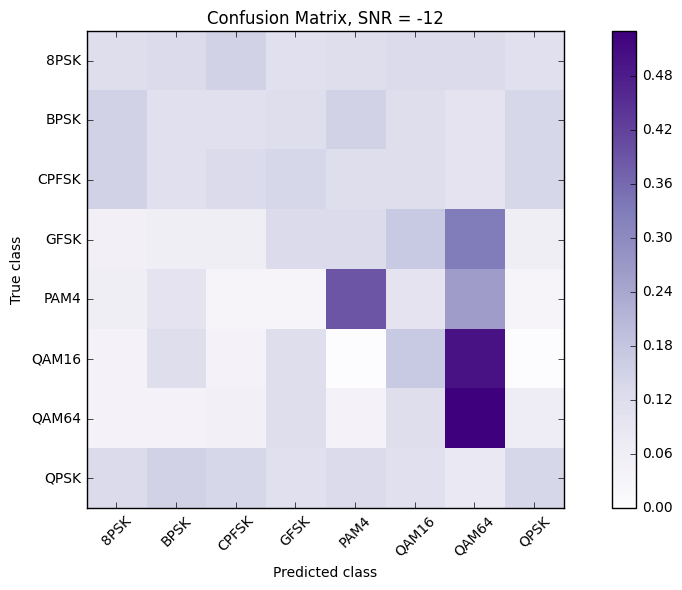

Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.13  0.13   0.13  0.12  0.12   0.13   0.12  0.13
BPSK   0.11  0.15   0.11  0.07  0.26   0.09   0.10  0.11
CPFSK  0.15  0.13   0.14  0.13  0.08   0.13   0.09  0.15
GFSK   0.06  0.08   0.05  0.25  0.09   0.20   0.22  0.06
PAM4   0.04  0.07   0.03  0.07  0.55   0.07   0.15  0.03
QAM16  0.06  0.02   0.06  0.06  0.06   0.17   0.52  0.07
QAM64  0.04  0.05   0.04  0.05  0.02   0.12   0.65  0.03
QPSK   0.16  0.16   0.16  0.14  0.09   0.11   0.04  0.14


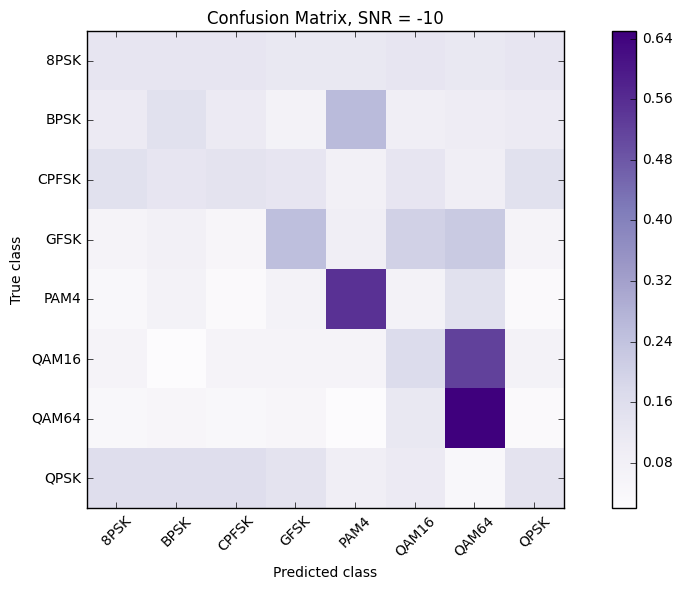

Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.16  0.14   0.17  0.13  0.03   0.12   0.07  0.17
BPSK   0.08  0.19   0.10  0.04  0.33   0.09   0.03  0.15
CPFSK  0.20  0.13   0.16  0.14  0.03   0.13   0.04  0.16
GFSK   0.06  0.04   0.10  0.35  0.05   0.22   0.10  0.08
PAM4   0.03  0.05   0.01  0.03  0.83   0.01   0.03  0.02
QAM16  0.04  0.05   0.07  0.07  0.05   0.21   0.48  0.05
QAM64  0.02  0.03   0.02  0.04  0.08   0.19   0.62  0.00
QPSK   0.20  0.19   0.19  0.10  0.03   0.08   0.03  0.16


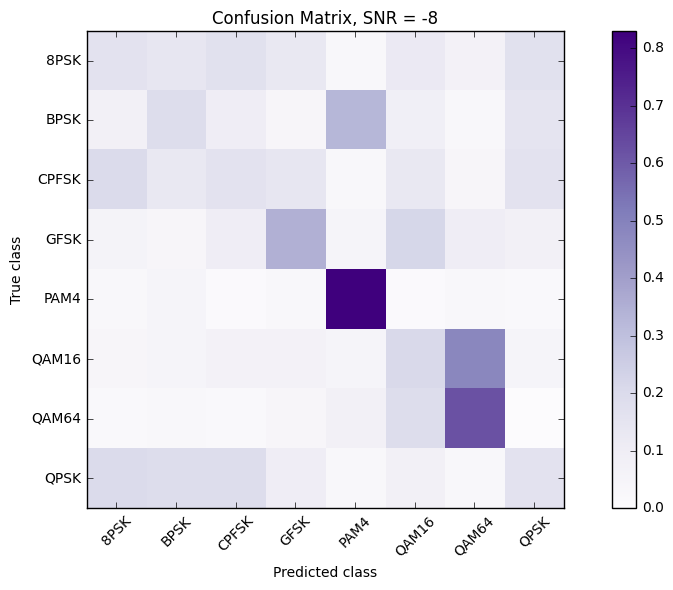

Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.17  0.17   0.18  0.10  0.00   0.14   0.05  0.20
BPSK   0.11  0.32   0.10  0.04  0.26   0.06   0.02  0.10
CPFSK  0.20  0.14   0.20  0.13  0.00   0.07   0.04  0.22
GFSK   0.12  0.06   0.14  0.45  0.00   0.12   0.02  0.09
PAM4   0.02  0.09   0.01  0.01  0.81   0.04   0.01  0.01
QAM16  0.03  0.06   0.04  0.06  0.03   0.34   0.40  0.05
QAM64  0.02  0.02   0.01  0.04  0.04   0.29   0.56  0.02
QPSK   0.24  0.15   0.21  0.08  0.01   0.06   0.02  0.24


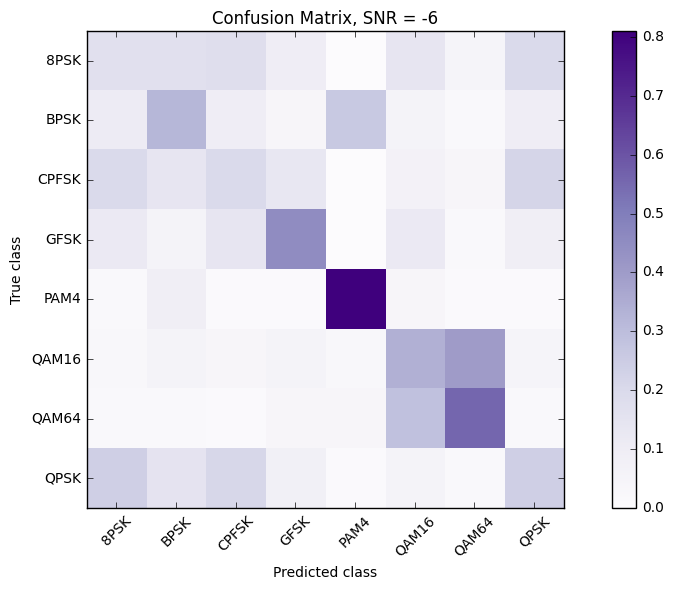

Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.24  0.05   0.20  0.08  0.00   0.09   0.06  0.29
BPSK   0.11  0.52   0.05  0.01  0.17   0.02   0.00  0.12
CPFSK  0.25  0.00   0.31  0.10  0.00   0.04   0.03  0.26
GFSK   0.12  0.03   0.22  0.49  0.00   0.03   0.01  0.10
PAM4   0.01  0.31   0.01  0.01  0.65   0.01   0.01  0.01
QAM16  0.06  0.04   0.07  0.07  0.00   0.29   0.33  0.15
QAM64  0.04  0.05   0.05  0.05  0.00   0.37   0.39  0.04
QPSK   0.31  0.04   0.23  0.07  0.00   0.06   0.04  0.26


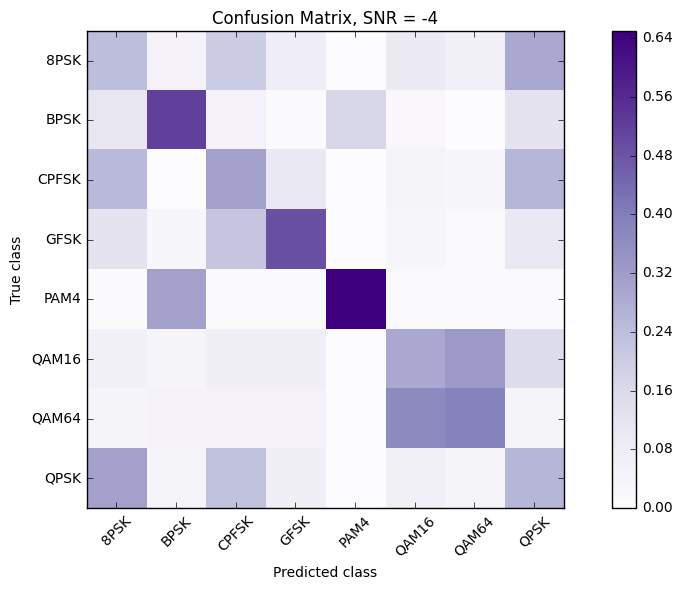

Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.37  0.00   0.17  0.06  0.00   0.08   0.08  0.24
BPSK   0.05  0.82   0.01  0.00  0.04   0.01   0.02  0.05
CPFSK  0.21  0.01   0.53  0.08  0.00   0.02   0.04  0.12
GFSK   0.10  0.00   0.12  0.65  0.00   0.02   0.01  0.11
PAM4   0.01  0.23   0.00  0.00  0.74   0.00   0.01  0.01
QAM16  0.10  0.02   0.10  0.05  0.00   0.27   0.27  0.19
QAM64  0.09  0.04   0.08  0.04  0.00   0.30   0.30  0.14
QPSK   0.29  0.01   0.18  0.03  0.01   0.09   0.08  0.32


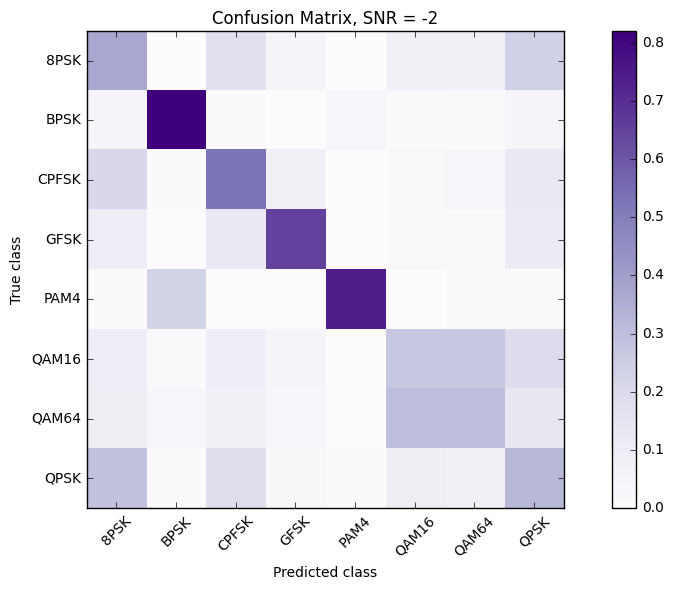

Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.39  0.00   0.17  0.18  0.00   0.07   0.09  0.09
BPSK   0.01  0.96   0.00  0.00  0.02   0.01   0.00  0.01
CPFSK  0.12  0.00   0.77  0.05  0.00   0.01   0.02  0.03
GFSK   0.06  0.00   0.04  0.85  0.00   0.02   0.01  0.02
PAM4   0.00  0.10   0.00  0.00  0.88   0.01   0.00  0.00
QAM16  0.12  0.00   0.04  0.02  0.00   0.24   0.20  0.38
QAM64  0.16  0.01   0.03  0.02  0.00   0.27   0.31  0.19
QPSK   0.14  0.03   0.01  0.02  0.03   0.21   0.21  0.36


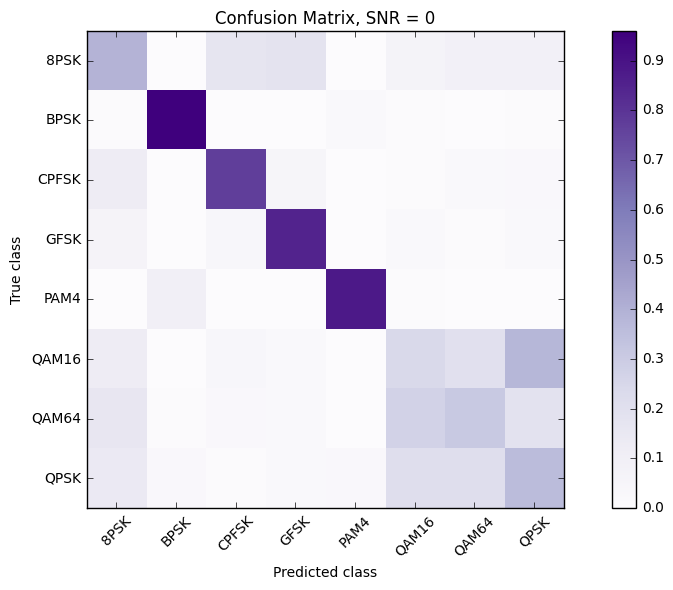

Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.55  0.00   0.09  0.16  0.00   0.07   0.06  0.06
BPSK   0.00  0.97   0.00  0.00  0.01   0.01   0.01  0.00
CPFSK  0.04  0.00   0.90  0.03  0.00   0.02   0.00  0.01
GFSK   0.04  0.00   0.00  0.94  0.00   0.01   0.00  0.00
PAM4   0.00  0.04   0.00  0.00  0.95   0.00   0.01  0.00
QAM16  0.10  0.00   0.00  0.00  0.00   0.27   0.26  0.37
QAM64  0.13  0.00   0.00  0.00  0.00   0.38   0.40  0.09
QPSK   0.02  0.02   0.00  0.01  0.01   0.10   0.08  0.76


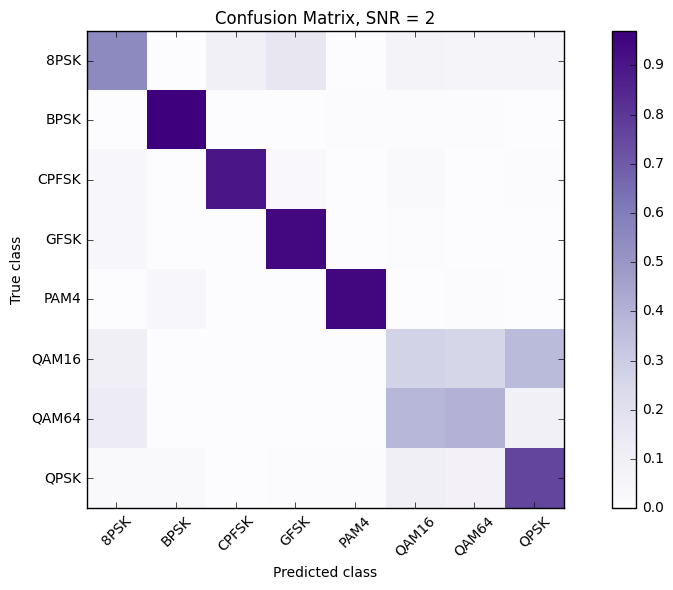

Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.74  0.00   0.02  0.04  0.01   0.07   0.08  0.05
BPSK   0.00  0.97   0.00  0.00  0.01   0.00   0.01  0.00
CPFSK  0.03  0.00   0.94  0.01  0.00   0.01   0.01  0.00
GFSK   0.02  0.00   0.01  0.94  0.00   0.00   0.02  0.00
PAM4   0.00  0.01   0.00  0.00  0.98   0.00   0.01  0.00
QAM16  0.04  0.00   0.00  0.00  0.00   0.47   0.38  0.11
QAM64  0.04  0.00   0.00  0.00  0.00   0.46   0.49  0.01
QPSK   0.03  0.01   0.00  0.00  0.01   0.06   0.04  0.87


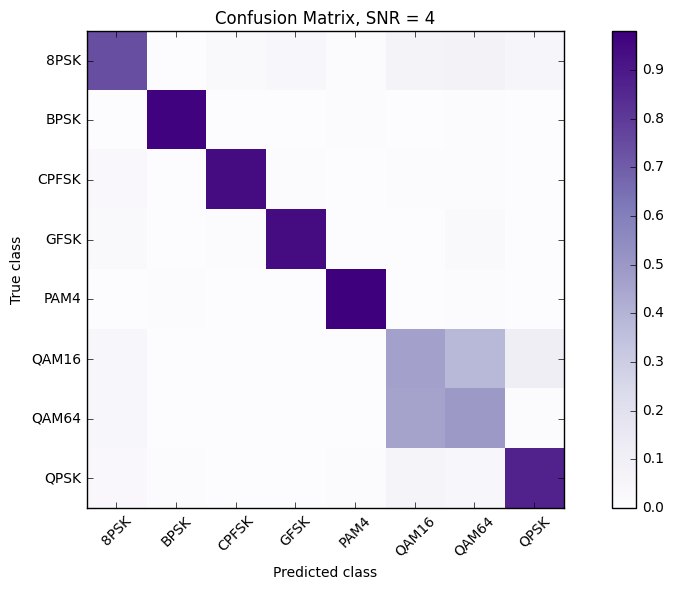

Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.80  0.00   0.00  0.00  0.00   0.09   0.08  0.03
BPSK   0.00  0.96   0.00  0.00  0.01   0.01   0.02  0.01
CPFSK  0.02  0.00   0.94  0.01  0.00   0.01   0.01  0.00
GFSK   0.02  0.00   0.01  0.96  0.00   0.00   0.01  0.00
PAM4   0.00  0.00   0.00  0.00  0.98   0.01   0.00  0.00
QAM16  0.04  0.00   0.00  0.00  0.00   0.55   0.37  0.04
QAM64  0.02  0.00   0.00  0.00  0.00   0.46   0.52  0.01
QPSK   0.03  0.01   0.00  0.00  0.00   0.06   0.03  0.87


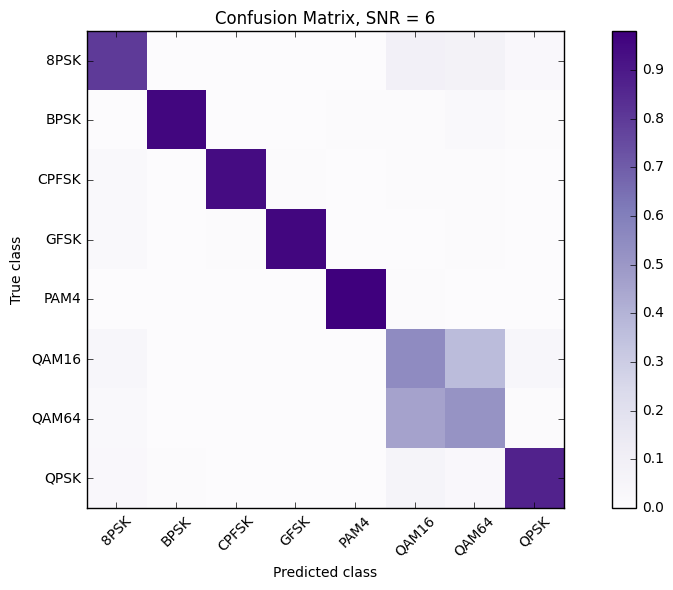

Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.81  0.00   0.00  0.00  0.00   0.09   0.07  0.03
BPSK   0.00  0.96   0.00  0.00  0.01   0.01   0.02  0.00
CPFSK  0.02  0.00   0.92  0.02  0.00   0.01   0.01  0.01
GFSK   0.02  0.00   0.00  0.97  0.00   0.00   0.01  0.00
PAM4   0.00  0.00   0.00  0.00  0.99   0.00   0.00  0.00
QAM16  0.01  0.00   0.00  0.00  0.00   0.50   0.47  0.03
QAM64  0.02  0.00   0.00  0.00  0.00   0.48   0.50  0.00
QPSK   0.04  0.01   0.00  0.00  0.00   0.08   0.04  0.83


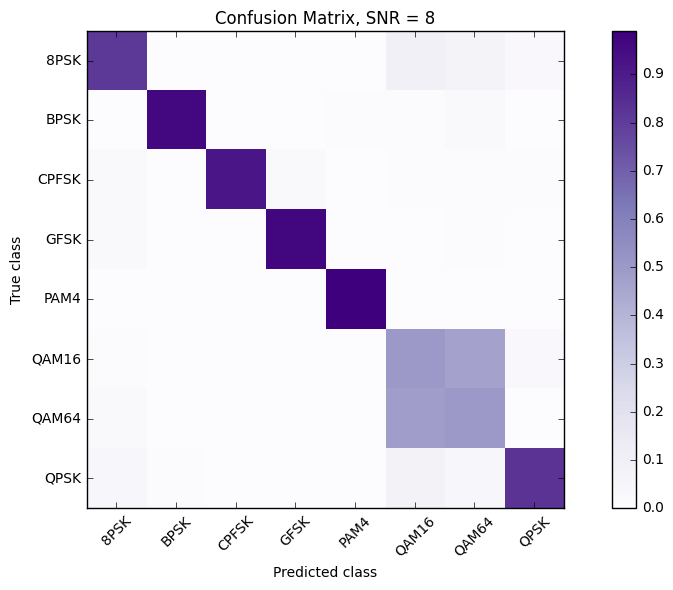

Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.83  0.00   0.00  0.00  0.00   0.08   0.07  0.02
BPSK   0.00  0.97   0.00  0.00  0.01   0.01   0.01  0.00
CPFSK  0.02  0.00   0.95  0.00  0.00   0.02   0.01  0.00
GFSK   0.02  0.00   0.00  0.94  0.00   0.01   0.02  0.00
PAM4   0.00  0.02   0.00  0.00  0.97   0.00   0.01  0.00
QAM16  0.03  0.00   0.00  0.00  0.00   0.53   0.44  0.00
QAM64  0.01  0.00   0.00  0.00  0.00   0.46   0.52  0.00
QPSK   0.03  0.00   0.00  0.00  0.00   0.06   0.04  0.87


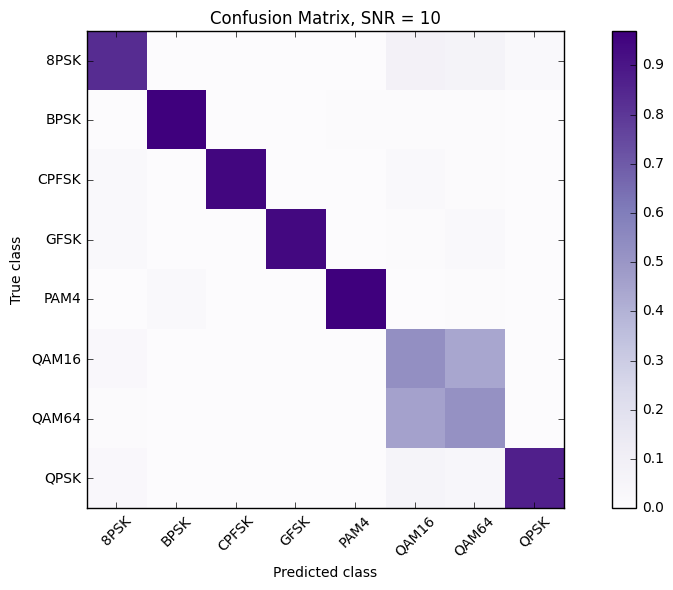

Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.86  0.00   0.00  0.00  0.00   0.09   0.04  0.00
BPSK   0.00  0.97   0.00  0.00  0.02   0.01   0.00  0.00
CPFSK  0.03  0.00   0.94  0.01  0.00   0.00   0.01  0.00
GFSK   0.03  0.00   0.00  0.93  0.00   0.01   0.03  0.00
PAM4   0.00  0.00   0.00  0.00  0.99   0.00   0.01  0.00
QAM16  0.03  0.00   0.00  0.00  0.00   0.58   0.38  0.02
QAM64  0.02  0.00   0.00  0.00  0.00   0.45   0.54  0.00
QPSK   0.05  0.00   0.00  0.00  0.00   0.04   0.06  0.85


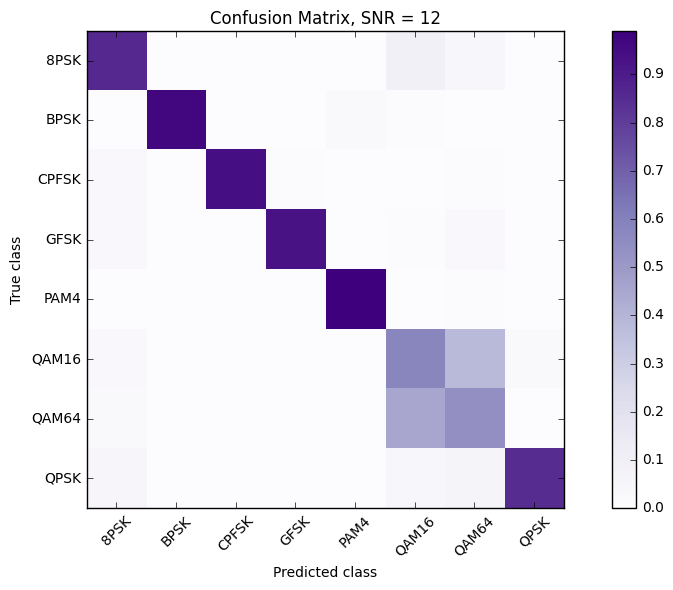

Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.79  0.00   0.00  0.00  0.00   0.09   0.09  0.02
BPSK   0.00  0.98   0.00  0.00  0.00   0.01   0.01  0.00
CPFSK  0.04  0.00   0.92  0.01  0.00   0.02   0.01  0.00
GFSK   0.02  0.00   0.00  0.95  0.00   0.01   0.01  0.00
PAM4   0.00  0.00   0.00  0.00  0.98   0.00   0.01  0.00
QAM16  0.04  0.00   0.00  0.00  0.00   0.51   0.44  0.01
QAM64  0.02  0.00   0.00  0.00  0.00   0.47   0.51  0.00
QPSK   0.04  0.01   0.00  0.00  0.00   0.04   0.03  0.88


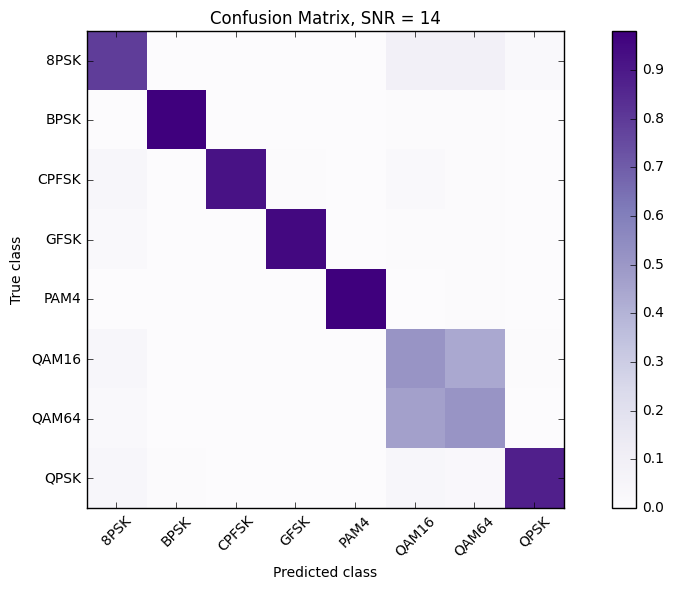

Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.81  0.00   0.00  0.00  0.00   0.08   0.09  0.01
BPSK   0.00  0.97   0.00  0.00  0.01   0.01   0.00  0.00
CPFSK  0.02  0.00   0.95  0.01  0.00   0.01   0.01  0.00
GFSK   0.04  0.00   0.00  0.94  0.00   0.00   0.01  0.00
PAM4   0.00  0.00   0.00  0.00  0.98   0.00   0.02  0.00
QAM16  0.03  0.00   0.00  0.00  0.00   0.53   0.44  0.01
QAM64  0.01  0.00   0.00  0.00  0.00   0.47   0.52  0.00
QPSK   0.03  0.01   0.00  0.00  0.01   0.07   0.03  0.85


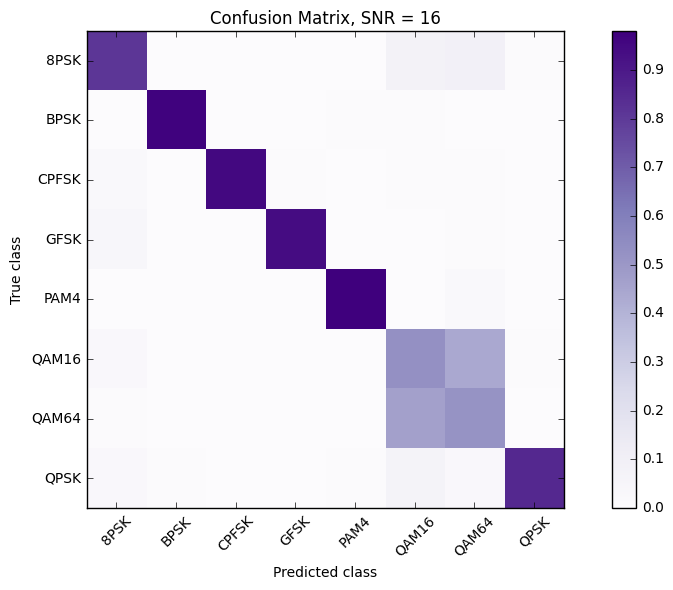

Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.83  0.00   0.00  0.00  0.00   0.07   0.08  0.01
BPSK   0.00  0.98   0.00  0.00  0.00   0.01   0.01  0.01
CPFSK  0.02  0.00   0.93  0.03  0.00   0.01   0.01  0.00
GFSK   0.02  0.00   0.00  0.97  0.00   0.00   0.00  0.00
PAM4   0.00  0.01   0.00  0.00  0.97   0.01   0.00  0.00
QAM16  0.05  0.01   0.00  0.00  0.00   0.54   0.40  0.00
QAM64  0.01  0.00   0.00  0.00  0.00   0.45   0.54  0.00
QPSK   0.03  0.00   0.00  0.00  0.00   0.08   0.03  0.86


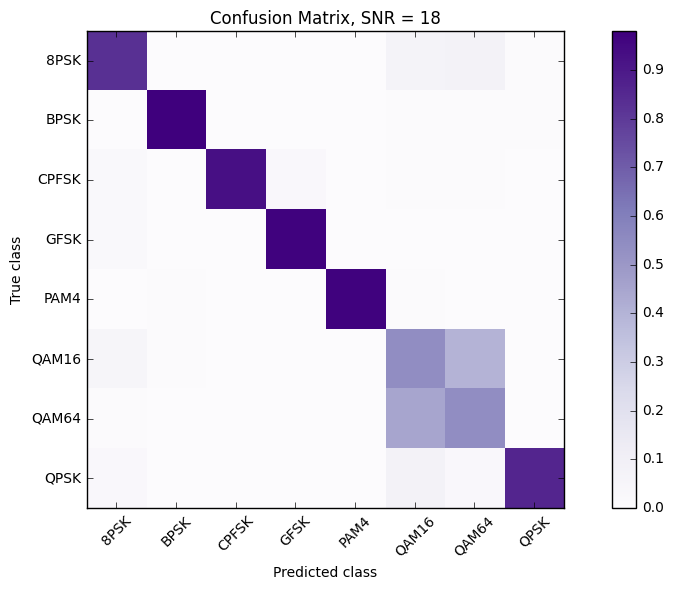

In [0]:

for snr in snrs:
  # Confusion Matrix
  classifier.predict(X_32test_std[snr], batch_size=batch_size)
  predicted_18dB = np.argmax(classifier.predict(X_32test_std[snr], batch_size=batch_size),axis=1) 

  classes = ['8PSK', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK']
  conf_matrix = confusion_matrix(predicted_18dB, y_32_test[snr])  

  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
  conf_matrix = conf_matrix.round(decimals = 2)

  import pandas as pd

  df = pd.DataFrame(data = conf_matrix, columns = classes, index = classes) 
  print("Confusion Matrix")
  print(df)

  fig1 = plt.figure(figsize=(10, 6), dpi=100)
  plt.imshow(conf_matrix, interpolation = 'nearest', cmap = plt.cm.Purples)
  ticks = np.arange(len(classes))
  plt.title("Confusion Matrix, SNR = %d" %snr)
  plt.xticks(ticks, classes, rotation=45)
  plt.yticks(ticks, classes)

  plt.ylabel('True class')
  plt.xlabel('Predicted class')

  plt.tight_layout()
  plt.colorbar()
  plt.show()